In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/segmentation/'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_dest_path = 'train_images/'

### Load data

In [7]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['Class'] = train['Image_Label'].apply(lambda x: x.split('_')[1])

# Only Gravel images
X_train = X_train[X_train['Gravel'] == 1]
X_val = X_val[X_val['Gravel'] == 1]
train = train[train['Class'] == 'Gravel']

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train
9,0dcd917.jpg,481752 562 483152 562 484552 562 485952 562 48...,NaN,14748 625 16148 625 17548 625 18948 625 20348 ...,78440 819 79840 819 81240 819 82640 819 84040 ...,1,0,1,1,train
10,d8cdb15.jpg,1003112 681 1004512 681 1005912 681 1007312 68...,1078320 1080 1079720 1080 1081120 1080 1082520...,44317 468 45717 468 47117 468 48517 468 49917 ...,12615 492 14015 492 15415 492 16815 492 18215 ...,1,1,1,1,train


# Model parameters

In [0]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 8
EPOCHS = 35
LEARNING_RATE = 3e-4
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 1
ES_PATIENCE = 8
RLROP_PATIENCE = 2
DECAY_DROP = 0.2
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

model_name = '62-unet_%s_%sx%s_(gravel)' % (BACKBONE, HEIGHT, WIDTH)
model_path = model_base_path + '%s.h5' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, 
                                                   shift_limit=0.1, border_mode=0, p=0.5)
                            ])

### Data generator

In [0]:
train_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [0]:
model = sm.FPN(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(None, None, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
# model.summary()

In [12]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=1).history



Epoch 1/35
292/292 [==============================] - 624s 2s/step - loss: 0.9879 - dice_coef: 0.5019 - iou_score: 0.3388 - f1-score: 0.5019 - val_loss: 0.9231 - val_dice_coef: 0.5772 - val_iou_score: 0.4089 - val_f1-score: 0.5772
Epoch 2/35
292/292 [==============================] - 584s 2s/step - loss: 0.8675 - dice_coef: 0.5587 - iou_score: 0.3907 - f1-score: 0.5587 - val_loss: 0.8676 - val_dice_coef: 0.5731 - val_iou_score: 0.4053 - val_f1-score: 0.5731
Epoch 3/35
292/292 [==============================] - 583s 2s/step - loss: 0.8378 - dice_coef: 0.5722 - iou_score: 0.4037 - f1-score: 0.5722 - val_loss: 0.8416 - val_dice_coef: 0.5918 - val_iou_score: 0.4250 - val_f1-score: 0.5918
Epoch 4/35
292/292 [==============================] - 584s 2s/step - loss: 0.8238 - dice_coef: 0.5813 - iou_score: 0.4128 - f1-score: 0.5813 - val_loss: 0.8446 - val_dice_coef: 0.5934 - val_iou_score: 0.4261 - val_f1-score: 0.5933
Epoch 5/35
292/292 [==============================] - 583s 2s/step - loss:

## Model loss graph

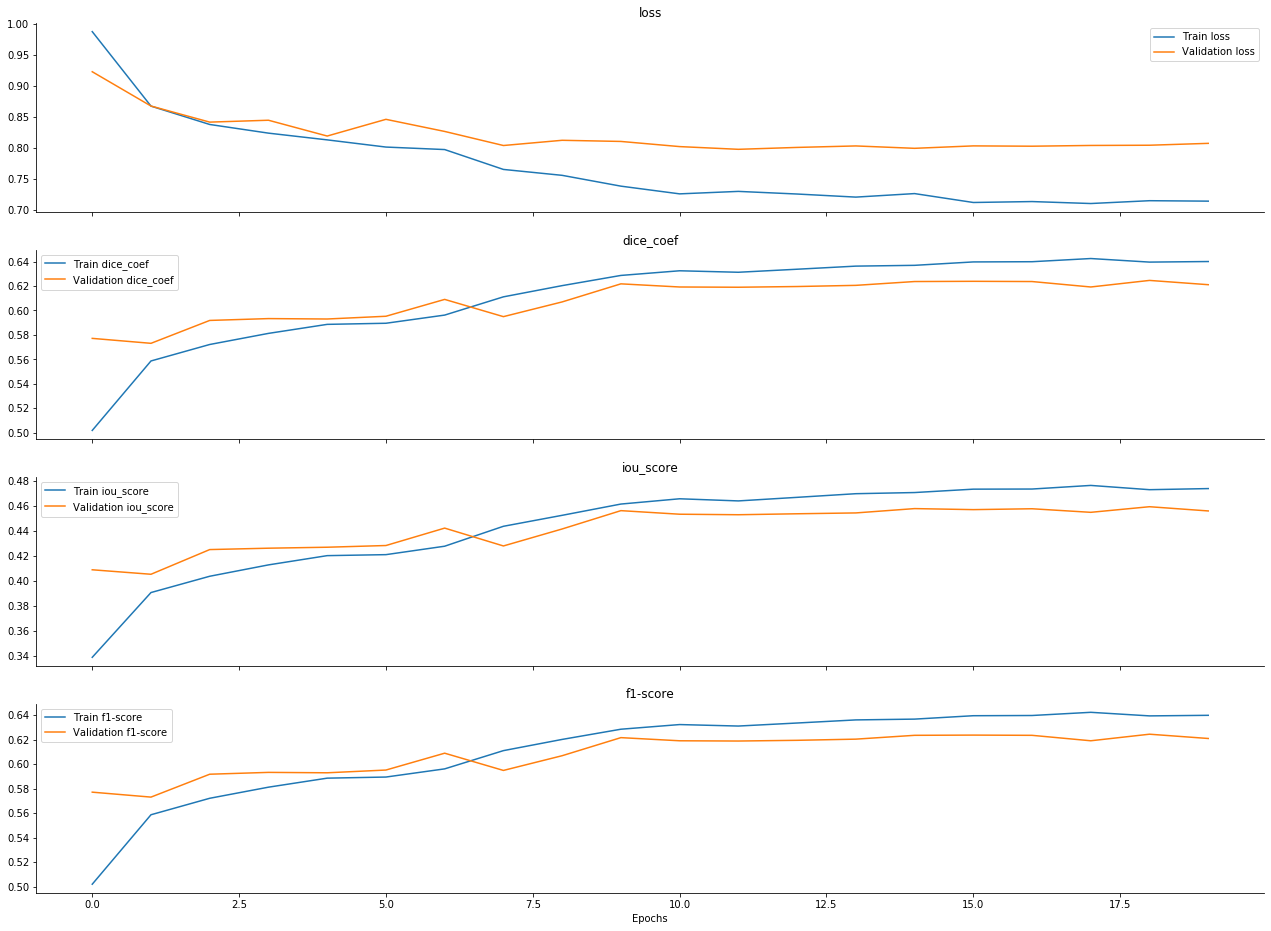

In [13]:
#@title
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])